# PTDF & LODF Geographic Sensitivity Analysis

Power Transfer Distribution Factors (PTDFs) and Line Outage Distribution
Factors (LODFs) reveal how power flows shift through the network in
response to transfers and contingencies. This notebook visualizes both
factors *entirely on geographic network maps*, making it easy to see
which corridors carry the transfer, where flow reroutes after an outage,
and how loading patterns change across the system.

```python
import numpy as np
from esapp import PowerWorld
from esapp.components import *

pw = PowerWorld(case_path)
```

In [1]:
import numpy as np
from esapp import PowerWorld
from esapp.components import *
import ast

with open('../data/case_B.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

pw = PowerWorld(case_path)

'open' took: 8.2118 sec


In [2]:
import sys; sys.path.insert(0, '..')
from plot_helpers import (
    plot_sensitivity_map, plot_sensitivity_dual, plot_sensitivity_triple,
    plot_flow_map, plot_bus_markers,
)

SHAPE = 'Texas'

## 1. Base Case Loading Map

Start by solving the base case and plotting every branch colored by
its loading percentage. Hot colors indicate heavily loaded lines.

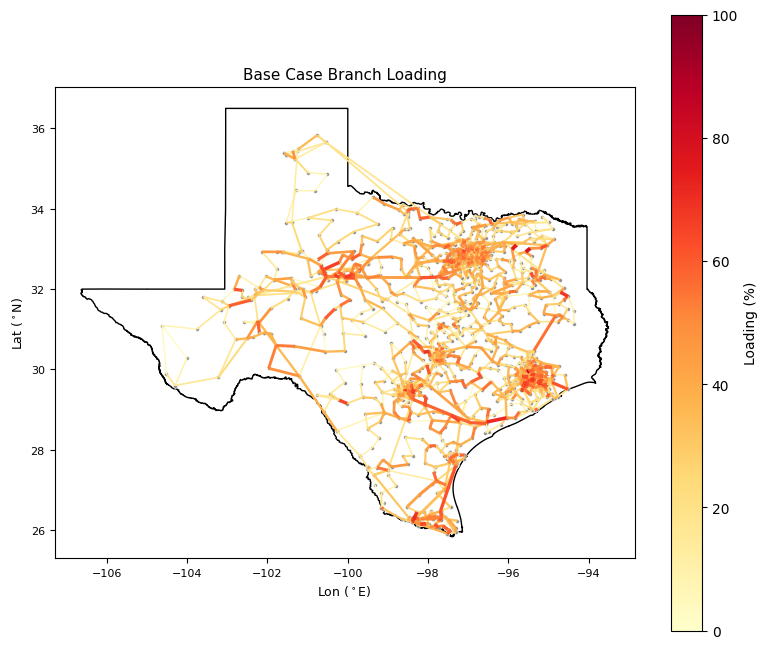

<Axes: title={'center': 'Base Case Branch Loading'}, xlabel='Lon ($^\\circ$E)', ylabel='Lat ($^\\circ$N)'>

In [3]:
pw.pflow()

geo_fields = ['BusNum', 'BusNum:1', 'LineCircuit',
              'Longitude', 'Longitude:1', 'Latitude', 'Latitude:1']
lines_geo = pw[Branch, geo_fields]
flows = pw.flows()

plot_flow_map(
    lines_geo, flows['LinePercent'].values,
    shape=SHAPE,
    title='Base Case Branch Loading',
    figsize=(8,8)
)

## 2. PTDF Transfer Corridor

PTDFs show what fraction of a seller-to-buyer transfer flows through
each line. Blue lines carry flow in the transfer direction; red lines
carry counter-flow. Thicker lines have larger absolute PTDFs.

The seller and buyer buses are marked with stars on the map.

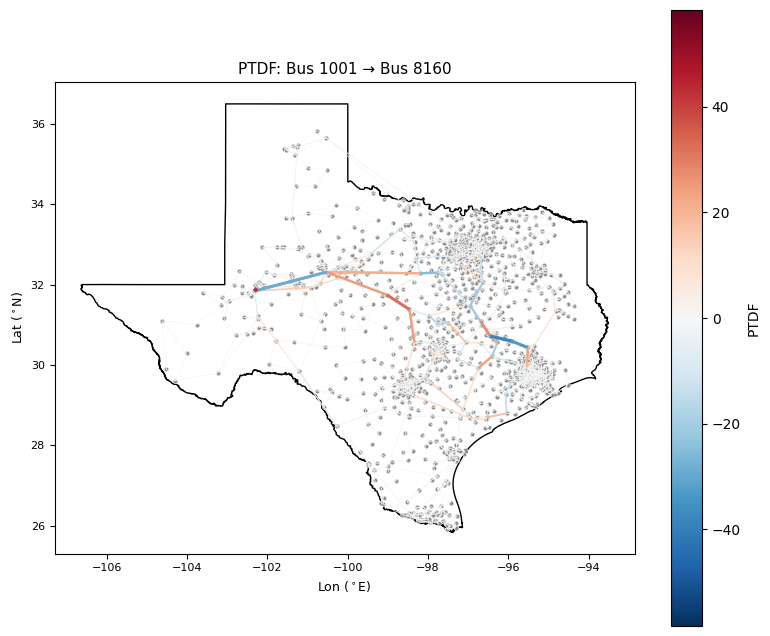

In [4]:
buses = pw[Bus, ['BusNum', 'BusPUVolt']]
lon, lat = pw.buscoords()

seller_bus = int(buses['BusNum'].iloc[0])
buyer_bus  = int(buses['BusNum'].iloc[-1])

ptdf_df = pw.ptdf(seller_bus, buyer_bus, method='DC')

ax = plot_sensitivity_map(
    lines_geo, ptdf_df['LinePTDF'].values,
    shape=SHAPE,
    title=f'PTDF: Bus {seller_bus} \u2192 Bus {buyer_bus}',
    clabel='PTDF',
    figsize=(8,8)
)

## 3. LODF Redistribution Pattern

When a branch trips, its flow redistributes across the remaining
network. LODFs quantify each line's share. The outaged branch is
shown as a dashed black line on the base-case loading map, then
the LODF pattern shows where the power reroutes.

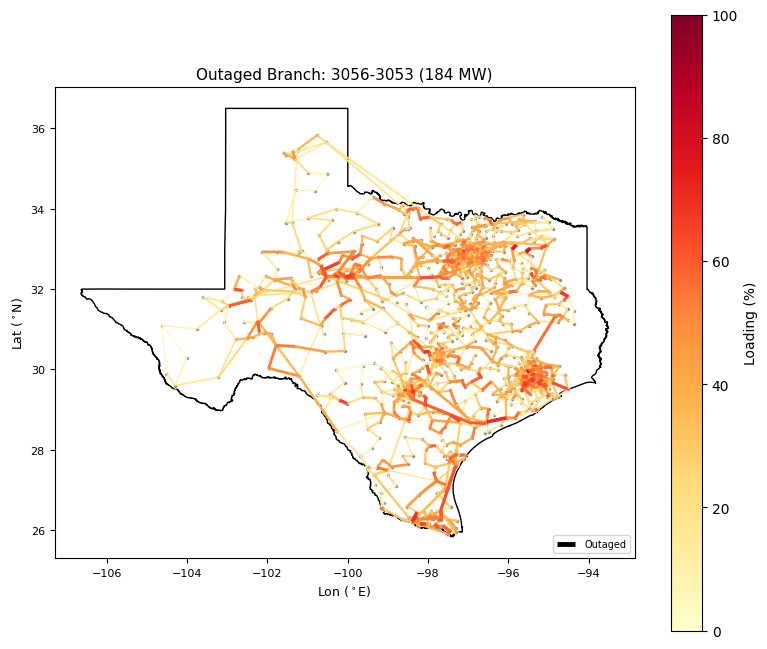

<Axes: title={'center': 'Outaged Branch: 3056-3053 (184 MW)'}, xlabel='Lon ($^\\circ$E)', ylabel='Lat ($^\\circ$N)'>

In [5]:
most_loaded_idx = flows['LinePercent'].idxmax()
branch_key = (
    int(flows.loc[most_loaded_idx, 'BusNum']),
    int(flows.loc[most_loaded_idx, 'BusNum:1']),
    str(flows.loc[most_loaded_idx, 'LineCircuit']),
)

# Show base loading with the outaged branch highlighted
plot_flow_map(
    lines_geo, flows['LinePercent'].values,
    shape=SHAPE,
    title=f'Outaged Branch: {branch_key[0]}-{branch_key[1]} '
          f'({flows.loc[most_loaded_idx, "LineMW"]:.0f} MW)',
    highlight_idx=most_loaded_idx,
    figsize=(8,8)
)

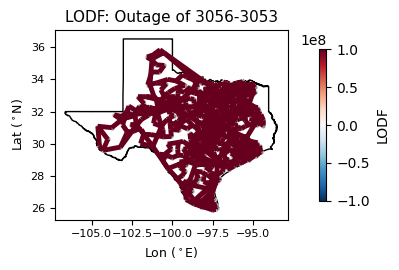

<Axes: title={'center': 'LODF: Outage of 3056-3053'}, xlabel='Lon ($^\\circ$E)', ylabel='Lat ($^\\circ$N)'>

In [6]:
lodf_df = pw.lodf(branch_key, method='DC')

plot_sensitivity_map(
    lines_geo, lodf_df['LineLODF'].values,
    shape=SHAPE,
    title=f'LODF: Outage of {branch_key[0]}-{branch_key[1]}',
    clabel='LODF',
)

## 4. PTDF vs LODF Side-by-Side

Placing the transfer corridor (PTDF) next to the outage redistribution
(LODF) reveals whether the same lines are critical for both scenarios.

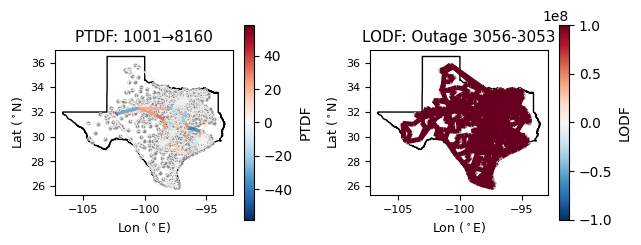

In [7]:
plot_sensitivity_dual(
    lines_geo,
    ptdf_df['LinePTDF'].values,
    lodf_df['LineLODF'].values,
    shape=SHAPE,
    titles=(
        f'PTDF: {seller_bus}\u2192{buyer_bus}',
        f'LODF: Outage {branch_key[0]}-{branch_key[1]}',
    ),
)

## 5. Estimated Post-Outage Loading

Using the LODF we can estimate post-contingency flows without
re-solving power flow:

$$f_k^{\text{post}} = f_k^{\text{pre}} + \text{LODF}_k \times f_{\text{outaged}}$$

The three-panel view below compares pre-outage loading, the estimated
flow change, and the resulting post-outage loading.

In [8]:
outaged_flow = flows.loc[most_loaded_idx, 'LineMW']
delta_mw = lodf_df['LineLODF'].values * outaged_flow
post_mw = flows['LineMW'].values + delta_mw

# Estimate post-outage loading (approximate using same MVA limit)
limits = flows['LineLimitMVA'].values
safe_limits = np.where(limits > 0, limits, 1.0)
post_loading = np.abs(post_mw) / safe_limits * 100

plot_sensitivity_triple(
    lines_geo,
    [flows['LinePercent'].values, delta_mw, post_loading],
    shape=SHAPE,
    titles=('Pre-Outage Loading', '\u0394 MW (LODF)', 'Est. Post-Outage Loading'),
    clabels=('Loading (%)', '\u0394 MW', 'Loading (%)'),
    cmaps=('YlOrRd', 'RdBu_r', 'YlOrRd'),
    symmetric=(False, True, False),
)

KeyError: 'LineLimitMVA'

## 6. Multiple Transfer Scenarios

Compare PTDF corridors for different seller-buyer pairs to identify
which transfers compete for the same network paths.

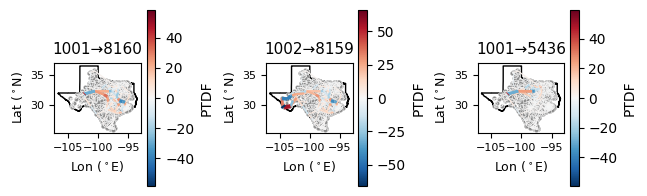

In [9]:
# Pick three distinct seller-buyer pairs
bus_list = buses['BusNum'].to_numpy()
pairs = [
    (int(bus_list[0]),  int(bus_list[-1])),
    (int(bus_list[1]),  int(bus_list[-2])),
    (int(bus_list[0]),  int(bus_list[len(bus_list)//2])),
]

ptdf_sets = []
pair_labels = []
for s_bus, b_bus in pairs:
    df = pw.ptdf(s_bus, b_bus, method='DC')
    ptdf_sets.append(df['LinePTDF'].values)
    pair_labels.append(f'{s_bus}\u2192{b_bus}')

plot_sensitivity_triple(
    lines_geo, ptdf_sets,
    shape=SHAPE,
    titles=pair_labels,
    clabels=('PTDF', 'PTDF', 'PTDF'),
)

## 7. Multiple Outage Scenarios

Compare LODF redistribution patterns for different branch outages
to see how the network responds to contingencies at different
locations.

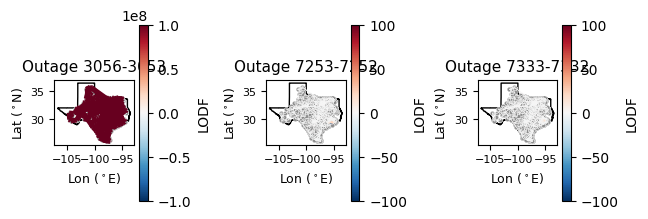

In [10]:
# Pick three most-loaded branches
top3 = flows['LinePercent'].nlargest(3)
lodf_sets = []
outage_labels = []
for idx in top3.index:
    bk = (
        int(flows.loc[idx, 'BusNum']),
        int(flows.loc[idx, 'BusNum:1']),
        str(flows.loc[idx, 'LineCircuit']),
    )
    df = pw.lodf(bk, method='DC')
    lodf_sets.append(df['LineLODF'].values)
    outage_labels.append(f'{bk[0]}-{bk[1]}')

plot_sensitivity_triple(
    lines_geo, lodf_sets,
    shape=SHAPE,
    titles=[f'Outage {l}' for l in outage_labels],
    clabels=('LODF', 'LODF', 'LODF'),
)

## 8. Worst-Case Overload Risk

For each branch, compute the maximum absolute LODF across all three
outage scenarios. Branches with high max-LODF are vulnerable to
overloading regardless of which contingency triggers.

In [ ]:
max_lodf = np.maximum.reduce([np.abs(v) for v in lodf_sets])

plot_sensitivity_map(
    lines_geo, max_lodf,
    shape=SHAPE,
    title='Worst-Case |LODF| Across Top 3 Outages',
    clabel='max |LODF|',
    cmap='inferno',
    symmetric=False,
)